# Past transactions

Trying to assess anomalous behaviour of accounts based on pattern of transaction

In [30]:
import pandas as pd
from matplotlib import pyplot as plt
from fbprophet import Prophet
from datetime import datetime
from sklearn import preprocessing
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from mlxtend.regressor import StackingRegressor
%matplotlib inline 

Get the datasets

In [2]:
successfulVends_raw = pd.read_csv("successfulVENDS2019.csv")
deposit_raw = pd.read_csv("deposit2019.csv")
loan_raw = pd.read_csv("loan2019.csv")

Rename columns for uniformity

In [3]:
deposit_raw= deposit_raw.rename(index=str,columns={"transamount":"amount","systemtranstime":"time"})

Extract account number,amount and timestamp

In [4]:
deposit= deposit_raw[['billrefnumber','amount','time']]

Convert to datetime type

In [5]:
deposit['time']=pd.to_datetime(deposit.time)

Group by each account

In [6]:
deposit_grouped = deposit.groupby(['billrefnumber','time']).sum()


Reset index since groupby makes time a column

In [7]:
deposit_grouped ['time'] = deposit_grouped.reset_index(level=1).time.values

Get time deltas

In [8]:
delta = []

for idx in deposit_grouped.index.levels[0]:
    
    delta.append( deposit_grouped.ix[idx].time.diff())
    
  

Make delta numeric and add to dataframe

In [9]:
from datetime import timedelta

In [10]:
d = [item/timedelta(days=1) for delt in delta for item in delt]

In [11]:
deposit_grouped['delta']=d


Get cumcount

In [12]:
deposit_cumcounts = deposit_grouped.groupby('billrefnumber').cumcount()
deposit = pd.concat([deposit_grouped,deposit_cumcounts], axis=1)
deposit.columns.values[3] = "cumcount"


In [13]:
deposit

amount                time      delta  \
billrefnumber time                                                         
0074836       2019-02-14 10:41:52   300.0 2019-02-14 10:41:52        NaN   
              2019-02-14 18:47:58   300.0 2019-02-14 18:47:58   0.337569   
01450001308   2019-03-26 03:18:21    50.0 2019-03-26 03:18:21        NaN   
              2019-03-26 12:37:23   300.0 2019-03-26 12:37:23   0.388218   
01450001316   2019-01-30 18:48:35   300.0 2019-01-30 18:48:35        NaN   
01450002009   2019-01-24 05:03:55   200.0 2019-01-24 05:03:55        NaN   
01450003551   2019-01-24 02:49:33   500.0 2019-01-24 02:49:33        NaN   
01450005036   2019-01-17 16:09:33  1000.0 2019-01-17 16:09:33        NaN   
01450005366   2019-01-24 10:09:23   300.0 2019-01-24 10:09:23        NaN   
01450005390   2019-01-13 06:43:06  1000.0 2019-01-13 06:43:06        NaN   
01450005408   2019-03-26 05:46:09   500.0 2019-03-26 05:46:09        NaN   
01450006299   2019-01-24 10:09:28   100.0 2019-01-24 10:09:28        NaN   
01450006315   2019-01-24 12:46:22    50.0 2019-01-24 12:46:22        NaN   
              2019-02-01 08:19:24   100.0 2019-02-01 08:19:24   7.814606   
01450009111   2019-01-23 15:02:52   250.0 2019-01-23 15:02:52        NaN   
              2019-01-31 01:59:14   150.0 2019-01-31 01:59:14   7.455810   
01450011745   2019-01-30 18:57:48   100.0 2019-01-30 18:57:48        NaN   
01450012131   2019-01-09 13:54:32   500.0 2019-01-09 13:54:32        NaN   
              2019-02-08 16:34:28   300.0 2019-02-08 16:34:28  30.111065   
              2019-02-08 17:53:10   200.0 2019-02-08 17:53:10   0.054653   
              2019-03-20 20:23:03  1000.0 2019-03-20 20:23:03  40.104086   
01450012560   2019-02-19 15:15:47   300.0 2019-02-19 15:15:47        NaN   
              2019-02-26 11:38:29   320.0 2019-02-26 11:38:29   6.849097   
01450014574   2019-02-22 07:44:21   500.0 2019-02-22 07:44:21        NaN   
01450014764   2019-01-24 08:15:27    20.0 2019-01-24 08:15:27        NaN   
01450015381   2019-02-05 16:16:18  1000.0 2019-02-05 16:16:18        NaN   
01450017064   2019-02-17 21:31:17   200.0 2019-02-17 21:31:17        NaN   
              2019-03-24 16:13:11   200.0 2019-03-24 16:13:11  34.779097   
01450018773   2019-03-16 09:35:06   500.0 2019-03-16 09:35:06        NaN   
01450019201   2019-03-26 06:40:20   100.0 2019-03-26 06:40:20        NaN   
...                                   ...                 ...        ...   
e37156484141  2019-01-24 13:19:10   180.0 2019-01-24 13:19:10        NaN   
e37166710030  2019-01-24 10:03:34    50.0 2019-01-24 10:03:34        NaN   
              2019-01-24 14:03:17    60.0 2019-01-24 14:03:17   0.166470   
              2019-01-24 14:05:45    20.0 2019-01-24 14:05:45   0.001713   
              2019-01-30 16:33:42    90.0 2019-01-30 16:33:42   6.102743   
              2019-01-30 16:37:08    20.0 2019-01-30 16:37:08   0.002384   
              2019-01-30 16:47:33    20.0 2019-01-30 16:47:33   0.007234   
              2019-01-30 16:52:04    20.0 2019-01-30 16:52:04   0.003137   
              2019-01-30 16:55:48    40.0 2019-01-30 16:55:48   0.002593   
              2019-01-30 17:00:05    20.0 2019-01-30 17:00:05   0.002975   
              2019-01-30 17:04:00    20.0 2019-01-30 17:04:00   0.002720   
              2019-01-30 17:20:59    20.0 2019-01-30 17:20:59   0.011794   
              2019-01-30 17:22:57    20.0 2019-01-30 17:22:57   0.001366   
              2019-01-30 17:32:41    20.0 2019-01-30 17:32:41   0.006759   
              2019-01-30 18:09:26    20.0 2019-01-30 18:09:26   0.025521   
              2019-01-30 18:19:06    40.0 2019-01-30 18:19:06   0.006713   
              2019-01-31 12:17:36    20.0 2019-01-31 12:17:36   0.748958   
              2019-01-31 12:26:27    20.0 2019-01-31 12:26:27   0.006146   
e37167805912  2019-03-01 18:37:45    20.0 2019-03-01 18:37:45        NaN   
e37167925546  2019-03-19 17:43:05   180.0 2019-03-19 17:43:05        NaN   
e371692

In [14]:
deposit = deposit.drop('time',axis=1)
deposit = deposit.reset_index()

Get sequences of account time delta

In [15]:
deposit_sequence = deposit.pivot(index='billrefnumber',columns='cumcount',values='delta')

Pad with max so that the sequences are of similar length

In [16]:
deposit_sequence = deposit_sequence.fillna(deposit_sequence.fillna(0).values.max())

Try to get clusters

In [19]:
from sklearn.cluster import KMeans

Get matrix of dataframe

In [20]:
X = deposit_sequence.values

Fit k means

In [21]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

Get predictions or clusters

In [22]:
y = kmeans.predict(X)


In [23]:
y

array([3, 3, 0, ..., 0, 0, 0], dtype=int32)

See sequences in cluster label 4

In [24]:
deposit_sequence.ix[np.argwhere(y == 4).flatten()]

cumcount,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
billrefnumber,,,,,,,,,,,,,,,,,,,,,
01450089832,84.063044,12.123484,4.065949,5.934201,7.051065,9.035150,8.653773,10.032164,8.821123,9.270799,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044
01450126154,84.063044,3.023067,2.075185,4.361863,8.551979,6.734722,0.213368,9.591690,1.381088,22.965579,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044
01450176845,84.063044,6.408530,3.897037,2.051748,8.902998,0.012315,0.579757,13.035289,2.926655,84.063044,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044
01450183429,84.063044,3.938819,4.504005,3.092512,5.935150,4.062338,3.911898,4.128125,4.970822,13.021667,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044
01450206568,84.063044,20.455440,4.575775,4.540243,4.710880,4.053553,4.114097,4.521806,4.119502,15.467350,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044
01450215031,84.063044,8.123588,15.941551,0.003252,3.955590,7.890903,8.092419,7.936771,7.128831,6.772824,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044
01450220577,84.063044,5.507639,5.402963,13.031829,6.087778,2.897222,3.108380,3.965984,8.290382,1.647014,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044
01450332232,84.063044,5.940475,3.790347,1.057593,2.195880,3.745208,4.072674,3.127894,4.108912,6.817095,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044
01450338700,84.063044,11.199884,8.954086,10.519977,13.123542,3.375220,4.039838,4.963356,7.978368,10.590498,...,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044,84.063044


Try to get right number of clu

In [26]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

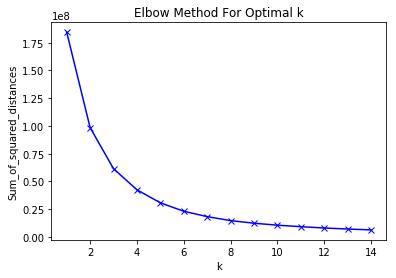

In [27]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [46]:
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.01)
clf.fit(X)
y = clf.predict(X)

In [47]:
y


array([1, 1, 1, ..., 1, 1, 1])

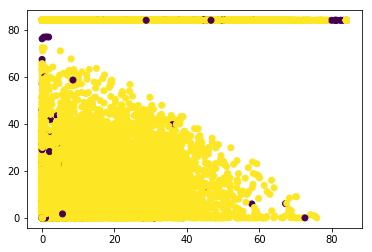

In [48]:
plt.scatter(x = X[:,1],y = X[:,2],c = y)

In [44]:
X[:,1]

array([  0.33756944,   0.38821759,  84.06304398, ...,  84.06304398,
        84.06304398,  84.06304398])